# K-Neighbour Nearest 

#importing libraries

In [26]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.neighbors import KNeighborsClassifier

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


from tqdm import tqdm

import os

# Loading Data

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('/home/ajay/Applied_course/amazon_datas/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning 

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

# Text preprocessing

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.

final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
for i, sent in enumerate(tqdm(final['Text'].values)):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    final_string.append(str1)

#############---- storing the data into .sqlite file ------########################
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")


100%|██████████| 364171/364171 [05:44<00:00, 1057.04it/s]


In [13]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [14]:
final.shape

(364171, 11)

In [15]:
positive = final[(final["Score"] ==1)]
print (positive.shape)


(307061, 11)


In [16]:
negative = final[(final["Score"] ==0)]
print (negative.shape)

(57110, 11)


In [17]:
positive_sample = positive[0:5000]
negative_sample = negative[0:5000]

In [18]:
positive_sample.shape

(5000, 11)

In [19]:
negative_sample.shape

(5000, 11)

In [20]:
final_data = [positive_sample, negative_sample]
final_sample = pd.concat(final_data)


In [21]:
final_sample.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [22]:
final_sample = final_sample.sort_values(by='Time')

In [23]:
final_sample.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


# (1). Bags of Words

In [32]:
#Breaking into Train and test
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(final_sample['CleanedText'].values,final_sample['Score'].values,test_size=0.3)

#Text -> Uni gram Vectors
bow = CountVectorizer(min_df=5,max_features=500) 
X_train = bow.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bow.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (7000, 500)
Test Data Size:  (3000, 500)


# Brute Force

In [33]:
#Using Grid search CV to find best value of k neighbour---

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best HyperParameter:  {'n_neighbors': 29}
Best Accuracy: 75.20%


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.6min finished


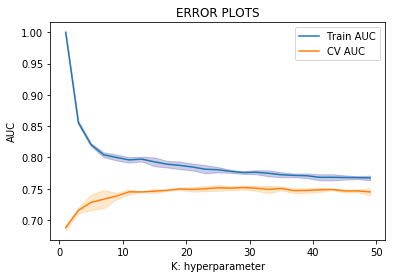

In [35]:
from sklearn.model_selection import GridSearchCV

K = np.arange(1,50,2)

knn = KNeighborsClassifier(algorithm='brute')
param_grid = {'n_neighbors':np.arange(1,50,2)}  
gsv = GridSearchCV(knn,param_grid,cv=3,verbose=1)
gsv.fit(X_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


In [36]:
#Testing with test data

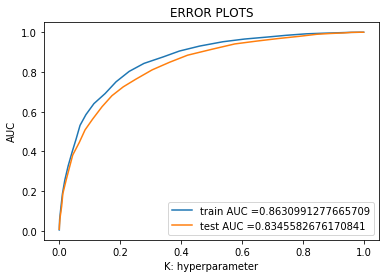

In [37]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=29 , algorithm='brute')
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Train data confusion matrix


Text(0.5,1,'Confusion Matrix')

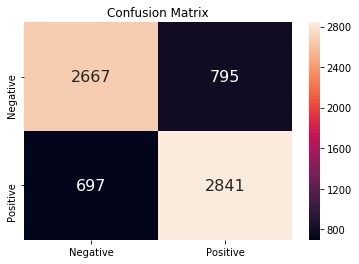

In [38]:
from sklearn.metrics import confusion_matrix
#Tain data
print("Train data confusion matrix")
conf_matrix = confusion_matrix(y_train,neigh.predict(X_train))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [56]:
from sklearn.metrics import  classification_report
print (classification_report(y_train,neigh.predict(X_train)))

             precision    recall  f1-score   support

          0       0.79      0.77      0.78      3462
          1       0.78      0.80      0.79      3538

avg / total       0.79      0.79      0.79      7000



Test data confusion matrix


Text(0.5,1,'Confusion Matrix')

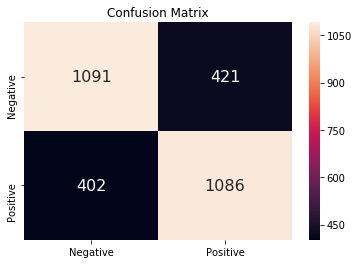

In [118]:
from sklearn.metrics import confusion_matrix
#Test data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(X_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [119]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(X_test)))

             precision    recall  f1-score   support

          0       0.73      0.72      0.73      1512
          1       0.72      0.73      0.73      1488

avg / total       0.73      0.73      0.73      3000



# kd-tree

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best HyperParameter:  {'n_neighbors': 29}
Best Accuracy: 75.20%


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.9min finished


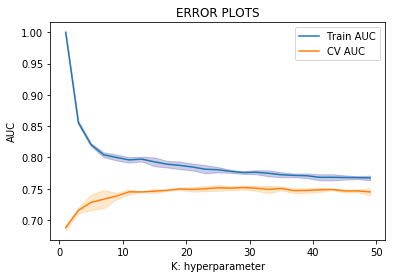

In [50]:
from sklearn.model_selection import GridSearchCV

K = np.arange(1,50,2)

knn = KNeighborsClassifier(algorithm='kd_tree')
param_grid = {'n_neighbors':np.arange(1,50,2)}  
gsv = GridSearchCV(knn,param_grid,cv=3,verbose=1)
gsv.fit(X_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


In [120]:
#Testing Data

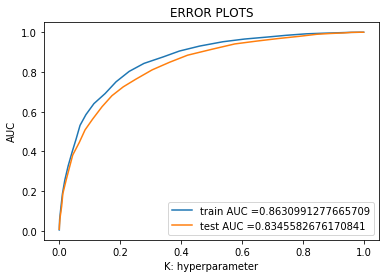

In [51]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=29 , algorithm='kd_tree')
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Train data confusion matrix


Text(0.5,1,'Confusion Matrix')

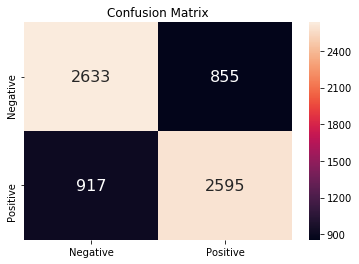

In [124]:
from sklearn.metrics import confusion_matrix
#Tain data
print("Train data confusion matrix")
conf_matrix = confusion_matrix(y_train,neigh.predict(X_train))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [123]:
#Accuracy on train data
from sklearn.metrics import  classification_report
print (classification_report(y_train,neigh.predict(X_train)))

             precision    recall  f1-score   support

          0       0.74      0.75      0.75      3488
          1       0.75      0.74      0.75      3512

avg / total       0.75      0.75      0.75      7000



Test data confusion matrix


Text(0.5,1,'Confusion Matrix')

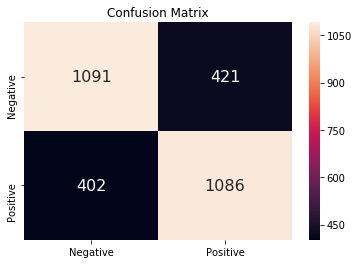

In [121]:
from sklearn.metrics import confusion_matrix
#Test data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(X_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [122]:
#Accuracy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(X_test)))

             precision    recall  f1-score   support

          0       0.73      0.72      0.73      1512
          1       0.72      0.73      0.73      1488

avg / total       0.73      0.73      0.73      3000



# (2).Tf-idf

In [57]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final_sample['CleanedText'].values,final_sample['Score'].values,test_size=0.3)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (7000, 196377)
Test Data Size:  (3000, 196377)


# Brute Algorithm

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best HyperParameter:  {'n_neighbors': 47}
Best Accuracy: 79.44%


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.8min finished


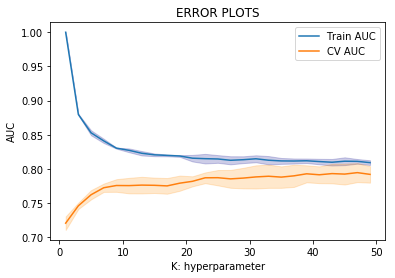

In [58]:
from sklearn.model_selection import GridSearchCV

K = np.arange(1,50,2)

knn = KNeighborsClassifier(algorithm='brute')
param_grid = {'n_neighbors':np.arange(1,50,2)}  
gsv = GridSearchCV(knn,param_grid,cv=3,verbose=1)
gsv.fit(X_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


In [125]:
#Testing Data

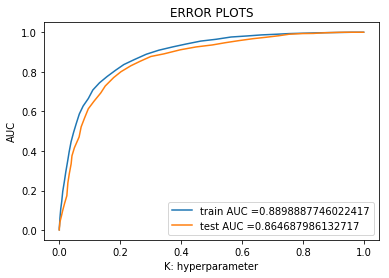

In [59]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=47 , algorithm='brute')
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Train data confusion matrix


Text(0.5,1,'Confusion Matrix')

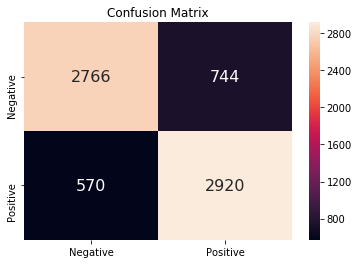

In [60]:
from sklearn.metrics import confusion_matrix
#Tain data
print("Train data confusion matrix")
conf_matrix = confusion_matrix(y_train,neigh.predict(X_train))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

Train data confusion matrix


Text(0.5,1,'Confusion Matrix')

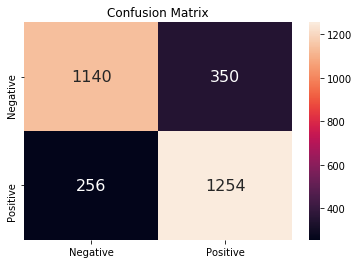

In [61]:
from sklearn.metrics import confusion_matrix
#Test data
print("Train data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(X_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [62]:
#Accuraccy on train data
from sklearn.metrics import  classification_report
print (classification_report(y_train,neigh.predict(X_train)))

             precision    recall  f1-score   support

          0       0.83      0.79      0.81      3510
          1       0.80      0.84      0.82      3490

avg / total       0.81      0.81      0.81      7000



In [63]:
#Accurracy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(X_test)))

             precision    recall  f1-score   support

          0       0.82      0.77      0.79      1490
          1       0.78      0.83      0.81      1510

avg / total       0.80      0.80      0.80      3000



# kd-tree

Training Data

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best HyperParameter:  {'n_neighbors': 55}
Best Accuracy: 79.74%


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.0min finished


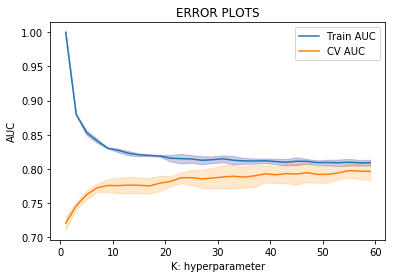

In [65]:
from sklearn.model_selection import GridSearchCV

K = np.arange(1,60,2)

knn = KNeighborsClassifier(algorithm='kd_tree')
param_grid = {'n_neighbors':np.arange(1,60,2)}  
gsv = GridSearchCV(knn,param_grid,cv=3,verbose=1)
gsv.fit(X_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Train data confusion matrix


Text(0.5,1,'Confusion Matrix')

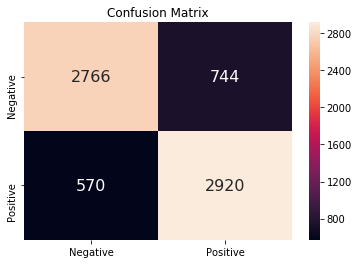

In [66]:
from sklearn.metrics import confusion_matrix
#Tain data
print("Train data confusion matrix")
conf_matrix = confusion_matrix(y_train,neigh.predict(X_train))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [67]:
#Accuraccy on train data
from sklearn.metrics import  classification_report
print (classification_report(y_train,neigh.predict(X_train)))

             precision    recall  f1-score   support

          0       0.83      0.79      0.81      3510
          1       0.80      0.84      0.82      3490

avg / total       0.81      0.81      0.81      7000



Test Data

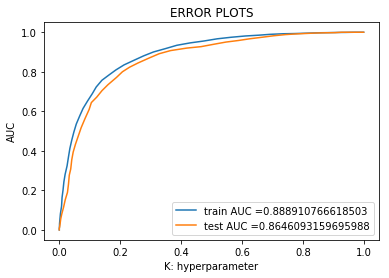

In [68]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=55 , algorithm='kd_tree')
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Train data confusion matrix


Text(0.5,1,'Confusion Matrix')

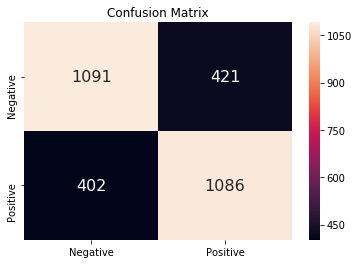

In [126]:
from sklearn.metrics import confusion_matrix
#Test data
print("Train data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(X_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [127]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(X_test)))

             precision    recall  f1-score   support

          0       0.73      0.72      0.73      1512
          1       0.72      0.73      0.73      1488

avg / total       0.73      0.73      0.73      3000



# (3). Word2Vec

In [71]:
# Train our own Word2Vec model using our own text corpus
list_of_sent=[]
for sent in final_sample['CleanedText'].values:
    list_of_sent.append(sent.split())

In [72]:
print(final_sample['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [73]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [74]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  5070


# Avg word2vec

In [75]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

10000
50


In [77]:
avg_vec_norm = preprocessing.normalize(sent_vectors)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,final_sample['Score'].values,test_size=0.3)

# Brute Force

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best HyperParameter:  {'n_neighbors': 13}
Best Accuracy: 73.59%


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.1min finished


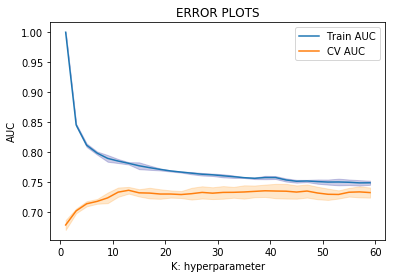

In [78]:
from sklearn.model_selection import GridSearchCV

K = np.arange(1,60,2)

knn = KNeighborsClassifier(algorithm='brute')
param_grid = {'n_neighbors':np.arange(1,60,2)}  
gsv = GridSearchCV(knn,param_grid,cv=3,verbose=1)
gsv.fit(X_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Testing data

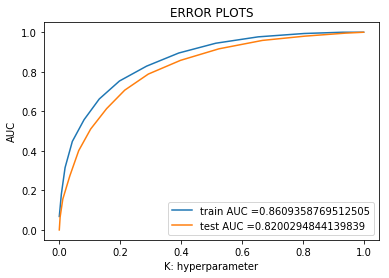

In [80]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=13 , algorithm='brute')
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Train data confusion matrix


Text(0.5,1,'Confusion Matrix')

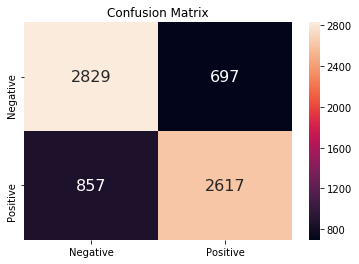

In [81]:
from sklearn.metrics import confusion_matrix
#Tain data
print("Train data confusion matrix")
conf_matrix = confusion_matrix(y_train,neigh.predict(X_train))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [84]:
#Accuraccy on train data
from sklearn.metrics import  classification_report
print (classification_report(y_train,neigh.predict(X_train)))

             precision    recall  f1-score   support

          0       0.77      0.80      0.78      3526
          1       0.79      0.75      0.77      3474

avg / total       0.78      0.78      0.78      7000



Train data confusion matrix


Text(0.5,1,'Confusion Matrix')

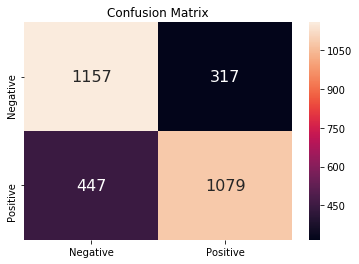

In [83]:
from sklearn.metrics import confusion_matrix
#Test  data
print("Train data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(X_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [86]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(X_test)))

             precision    recall  f1-score   support

          0       0.72      0.78      0.75      1474
          1       0.77      0.71      0.74      1526

avg / total       0.75      0.75      0.75      3000



# Kd-Tree Algorithm

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best HyperParameter:  {'n_neighbors': 13}
Best Accuracy: 73.60%


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.4min finished


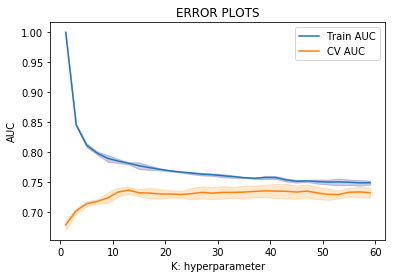

In [87]:
from sklearn.model_selection import GridSearchCV

K = np.arange(1,60,2)

knn = KNeighborsClassifier(algorithm='kd_tree')
param_grid = {'n_neighbors':np.arange(1,60,2)}  
gsv = GridSearchCV(knn,param_grid,cv=3,verbose=1)
gsv.fit(X_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Testing data

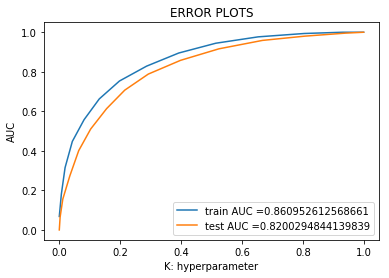

In [88]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=13 , algorithm='kd_tree')
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Train data confusion matrix


Text(0.5,1,'Confusion Matrix')

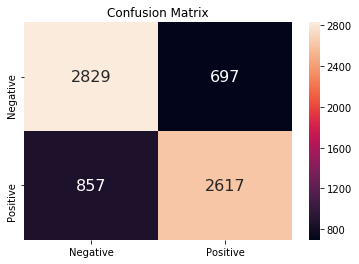

In [89]:
from sklearn.metrics import confusion_matrix
#Train  data
print("Train data confusion matrix")
conf_matrix = confusion_matrix(y_train,neigh.predict(X_train))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [90]:
#Accuraccy on train data
from sklearn.metrics import  classification_report
print (classification_report(y_train,neigh.predict(X_train)))

             precision    recall  f1-score   support

          0       0.77      0.80      0.78      3526
          1       0.79      0.75      0.77      3474

avg / total       0.78      0.78      0.78      7000



Test data confusion matrix


Text(0.5,1,'Confusion Matrix')

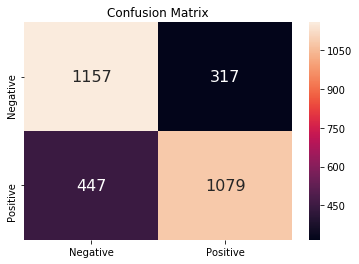

In [91]:
from sklearn.metrics import confusion_matrix
#Test  data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(X_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [92]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(X_test)))

             precision    recall  f1-score   support

          0       0.72      0.78      0.75      1474
          1       0.77      0.71      0.74      1526

avg / total       0.75      0.75      0.75      3000



# (4). TF-idf W2Vec

In [93]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final_sample['CleanedText'].values)

type(final_tf_idf)

scipy.sparse.csr.csr_matrix

In [94]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

In [95]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [97]:
tfidfw2v_vecs_norm = preprocessing.normalize(tfidf_sent_vectors)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(tfidfw2v_vecs_norm,final_sample['Score'].values,test_size=0.3)

# Brute Force

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best HyperParameter:  {'n_neighbors': 31}
Best Accuracy: 72.31%


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.1min finished


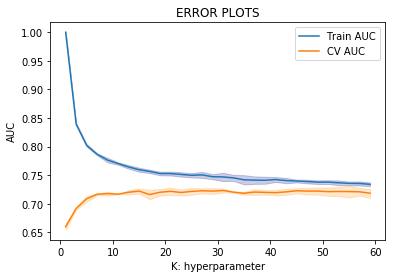

In [98]:
from sklearn.model_selection import GridSearchCV

K = np.arange(1,60,2)

knn = KNeighborsClassifier(algorithm='brute')
param_grid = {'n_neighbors':np.arange(1,60,2)}  
gsv = GridSearchCV(knn,param_grid,cv=3,verbose=1)
gsv.fit(X_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Testing data

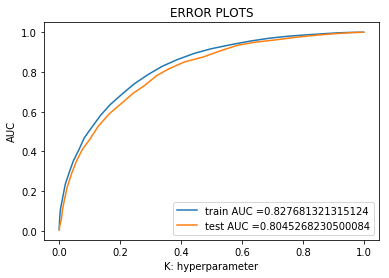

In [99]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=31 , algorithm='brute')
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Test data confusion matrix


Text(0.5,1,'Confusion Matrix')

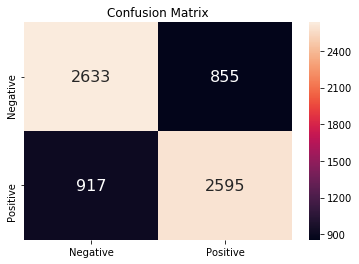

In [100]:
from sklearn.metrics import confusion_matrix
#Train  data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_train,neigh.predict(X_train))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [103]:
#Accuraccy on train data
from sklearn.metrics import  classification_report
print (classification_report(y_train,neigh.predict(X_train)))

             precision    recall  f1-score   support

          0       0.74      0.75      0.75      3488
          1       0.75      0.74      0.75      3512

avg / total       0.75      0.75      0.75      7000



Test data confusion matrix


Text(0.5,1,'Confusion Matrix')

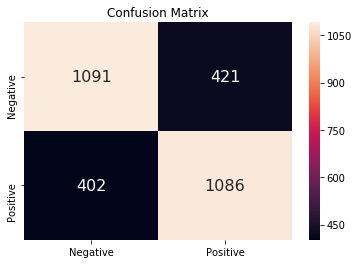

In [101]:
from sklearn.metrics import confusion_matrix
#Test  data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(X_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [104]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(X_test)))

             precision    recall  f1-score   support

          0       0.73      0.72      0.73      1512
          1       0.72      0.73      0.73      1488

avg / total       0.73      0.73      0.73      3000



# Kd-Tree Algorithm

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best HyperParameter:  {'n_neighbors': 31}
Best Accuracy: 72.31%


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.1min finished


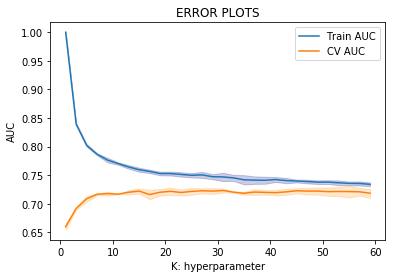

In [105]:
from sklearn.model_selection import GridSearchCV

K = np.arange(1,60,2)

knn = KNeighborsClassifier(algorithm='kd_tree')
param_grid = {'n_neighbors':np.arange(1,60,2)}  
gsv = GridSearchCV(knn,param_grid,cv=3,verbose=1)
gsv.fit(X_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Testing data

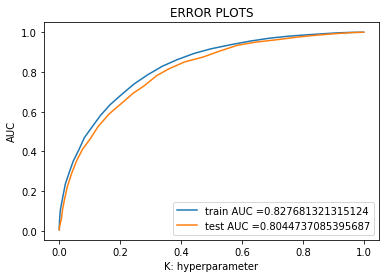

In [106]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=31 , algorithm='kd_tree')
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Train data confusion matrix


Text(0.5,1,'Confusion Matrix')

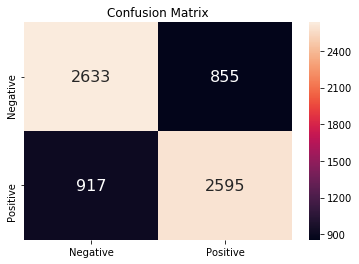

In [108]:
from sklearn.metrics import confusion_matrix
#Train  data
print("Train data confusion matrix")
conf_matrix = confusion_matrix(y_train,neigh.predict(X_train))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [109]:
#Accuraccy on train data
from sklearn.metrics import  classification_report
print (classification_report(y_train,neigh.predict(X_train)))

             precision    recall  f1-score   support

          0       0.74      0.75      0.75      3488
          1       0.75      0.74      0.75      3512

avg / total       0.75      0.75      0.75      7000



Test data confusion matrix


Text(0.5,1,'Confusion Matrix')

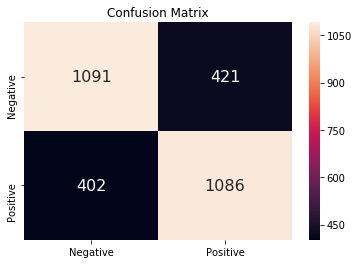

In [110]:
from sklearn.metrics import confusion_matrix
#Test  data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(X_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [111]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(X_test)))

             precision    recall  f1-score   support

          0       0.73      0.72      0.73      1512
          1       0.72      0.73      0.73      1488

avg / total       0.73      0.73      0.73      3000



# PrettyTable 

In [130]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper parameter", "AUC"]

x.add_row(["BOW", "Brute",29 ,75.20 ])
x.add_row([" " , "kd_tree",29 ,75.20 ])
x.add_row(["TFIDF", "Brute",47 ,79.44 ])
x.add_row([" ", "kd_tree",55 ,79.74 ])
x.add_row(["W2V", "Brute",13 ,73.59 ])
x.add_row([" ", "kd_tree",13 ,73.60 ])
x.add_row(["TFIDFW2V", "Brute", 31, 72.31 ])
x.add_row(["", "kd_tree",31 , 72.31 ])

print (x)

+------------+---------+-----------------+-------+
| Vectorizer |  Model  | Hyper parameter |  AUC  |
+------------+---------+-----------------+-------+
|    BOW     |  Brute  |        29       |  75.2 |
|            | kd_tree |        29       |  75.2 |
|   TFIDF    |  Brute  |        47       | 79.44 |
|            | kd_tree |        55       | 79.74 |
|    W2V     |  Brute  |        13       | 73.59 |
|            | kd_tree |        13       |  73.6 |
|  TFIDFW2V  |  Brute  |        31       | 72.31 |
|            | kd_tree |        31       | 72.31 |
+------------+---------+-----------------+-------+


# Conclusions-

Note- I have taken only 10000 data due to high training time so the actual accuraccy of data can be increase. 



I have used Grid Search Cv for cross validation of data 



1). kd-tree and Brute algo implementation give same results 



2). Best accuraccy was obtained by TFIDF 



3). Most important KNN is slow algorithm since it takes lot of time to train